- **Exploratory analysis**: Perform exploratory data analysis using numerical and visual 
summary methods. Share the insights that you find most useful from this analysis.  
- **Model building and evaluation**: Develop a linear regression model to explain the 
variation in wage. In the main body of the report, you should only present the best 
model that you finally choose and explain why you choose this model. In the 
appendix, please provide the other models that you have evaluated and the 
corresponding analysis results.  
- **Interpretation of results**: Please answer the following questions in your report:  
  - Which variables matter (statistically and economically) in explaining hourly wages? 
  - Are there significant differences in wages based on geographical location, occupation, or industry? Please explain.
  - Do demographic variables like race and gender significantly influence wages? If so, in what way? 
  - Are there any additional insights that you find interesting and relevant from the analysis? 
  - Which other variables do you think might matter for explaining variation in the wage but are not currently in the dataset?

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_theme(style="whitegrid")

# Data provided by staff.
df = pd.read_csv("wage.csv")

### Exploration

#### Wage

In [52]:
# Plot KDE with Mean and Median on a specific axis.
def plot_kde_on_ax(ax, data_series, title, xlabel, color):
    """
    Generates a KDE plot on a specified matplotlib axes, showing its mean and median.

    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        data_series (pd.Series): The data to plot.
        title (str): Title for the subplot.
        xlabel (str): Label for the x-axis.
        color (str): Color for the KDE plot.
    """
    mean_val = data_series.mean()
    median_val = data_series.median()

    sns.kdeplot(x=data_series, fill=True, color=color, linewidth=2, ax=ax)

    ax.axvline(
        mean_val,
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Mean: ${mean_val:,.2f}",
    )
    ax.axvline(
        median_val,
        color="green",
        linestyle=":",
        linewidth=2,
        label=f"Median: ${median_val:,.2f}",
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.7)

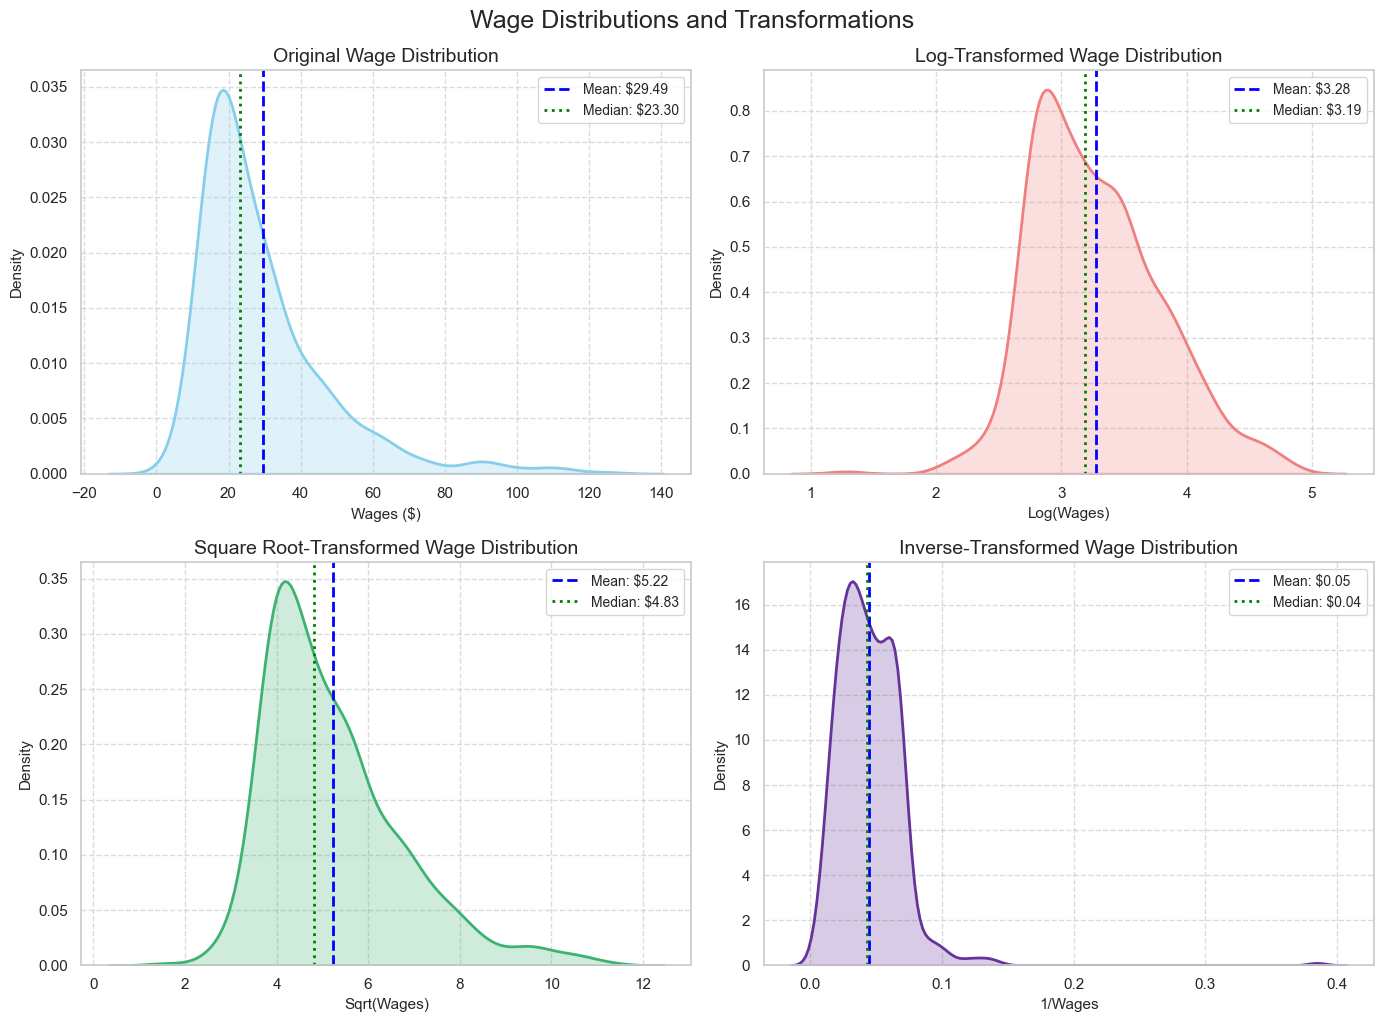

In [53]:
# Data Transformations to reduce right-skewness.
df["wage_log"] = np.log(df.wage + 1)  # Add a tiny constant to avoid log(0)
df["wage_sqrt"] = np.sqrt(df.wage)
df["wage_inverse"] = 1 / df.wage

# 2x2 matrix plot setup.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
# Flatten the axes array for easy iteration (axes[0,0], axes[0,1], axes[1,0], axes[1,1])
axes = axes.flatten()

plot_configs = [
    {
        "column": "wage",
        "title": "Original Wage Distribution",
        "xlabel": "Wages ($)",
        "color": "skyblue",
    },
    {
        "column": "wage_log",
        "title": "Log-Transformed Wage Distribution",
        "xlabel": "Log(Wages)",
        "color": "lightcoral",
    },
    {
        "column": "wage_sqrt",
        "title": "Square Root-Transformed Wage Distribution",
        "xlabel": "Sqrt(Wages)",
        "color": "mediumseagreen",
    },
    {
        "column": "wage_inverse",
        "title": "Inverse-Transformed Wage Distribution",
        "xlabel": "1/Wages",
        "color": "rebeccapurple",
    },
]

for i, config in enumerate(plot_configs):
    plot_kde_on_ax(
        axes[i],
        df[config["column"]],
        config["title"],
        config["xlabel"],
        config["color"],
    )

plt.tight_layout()  # Adjusts subplot params for a tight layout
plt.suptitle(
    "Wage Distributions and Transformations", fontsize=18, y=1.02
)  # Overall title
plt.show()

The distribution density graph above presents the following characteristics:
- A simple visual inspection indicates the distribution is right skewed.
- This is supported by the median ($23.3) being smaller than the mean ($29.49).
- When it comes to using the remaning dimensions to predict `wage` it might be worth exploring the transformation of `wage`, in order to smooth its distribution.

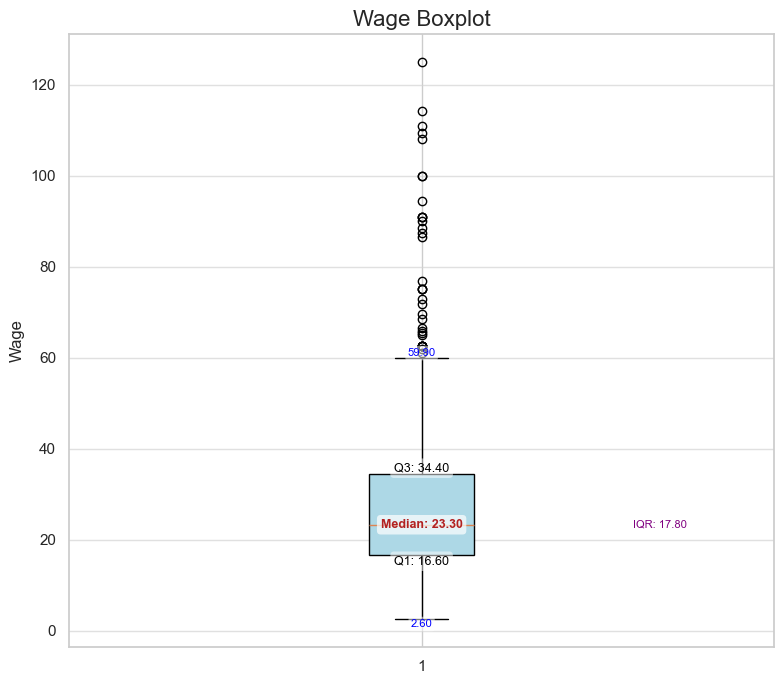

In [54]:
data_to_plot = [df.wage]  # boxplot expects a list of datasets, even for one

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 7))  # Adjusted figsize slightly for a single plot

# Create the boxplot
# patch_artist=True allows us to fill the box with color
# vert=True makes the boxplot vertical (default)
bp = ax.boxplot(data_to_plot, patch_artist=True, vert=True)

# Define a color for the box
box_color = "lightblue"

# Since there's only one box, we access its components directly using index 0
# instead of looping.

# Change box color
bp["boxes"][0].set_facecolor(box_color)

# Get the x-coordinate for the center of the box
# This can be used for placing Q1, Median, Q3 labels
box_center_x = bp["medians"][0].get_xdata().mean()

# --- Q1 (25th percentile) ---
# The bottom of the box represents Q1
q1 = bp["boxes"][0].get_path().vertices[0, 1]
ax.text(
    box_center_x,
    q1,
    f"Q1: {q1:.2f}",
    va="top",
    ha="center",
    color="black",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5, ec="none"),
)

# --- Median (50th percentile) ---
median_val = bp["medians"][0].get_ydata()[0]
ax.text(
    box_center_x,
    median_val,
    f"Median: {median_val:.2f}",
    va="center",
    ha="center",
    color="firebrick",
    fontsize=9,
    fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, ec="none"),
)

# --- Q3 (75th percentile) ---
# The top of the box represents Q3
q3 = bp["boxes"][0].get_path().vertices[2, 1]
ax.text(
    box_center_x,
    q3,
    f"Q3: {q3:.2f}",
    va="bottom",
    ha="center",
    color="black",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5, ec="none"),
)

# --- Whiskers ---
# bp['whiskers'] contains two Line2D objects for the single boxplot:
# bp['whiskers'][0] is the lower whisker
# bp['whiskers'][1] is the upper whisker

# Lower whisker end
lower_whisker_line = bp["whiskers"][0]
lw_val = lower_whisker_line.get_ydata()[1]  # End point of the lower whisker
lw_x = lower_whisker_line.get_xdata()[0]  # X-coordinate of the whisker
ax.text(
    lw_x,
    lw_val,
    f"{lw_val:.2f}",
    va="top",
    ha="center",
    color="blue",
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.5, ec="none"),
)

# Upper whisker end
upper_whisker_line = bp["whiskers"][1]
uw_val = upper_whisker_line.get_ydata()[1]  # End point of the upper whisker
uw_x = upper_whisker_line.get_xdata()[0]  # X-coordinate of the whisker
ax.text(
    uw_x,
    uw_val,
    f"{uw_val:.2f}",
    va="bottom",
    ha="center",
    color="blue",
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.5, ec="none"),
)

# --- Interquartile Range (IQR) --- (Optional)
iqr = q3 - q1
ax.text(
    box_center_x + 0.3,
    median_val,
    f"IQR: {iqr:.2f}",  # Offset x for clarity
    va="center",
    ha="left",
    color="purple",
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5, ec="none"),
)

# Add some styling to the plot
ax.set_title("Wage Boxplot", fontsize=16)
ax.set_ylabel("Wage", fontsize=12)
# ax.set_xlabel('Group', fontsize=12) # X-label might be less necessary for a single plot
ax.yaxis.grid(True, linestyle="-", which="major", color="lightgrey", alpha=0.7)

plt.tight_layout()
plt.show()

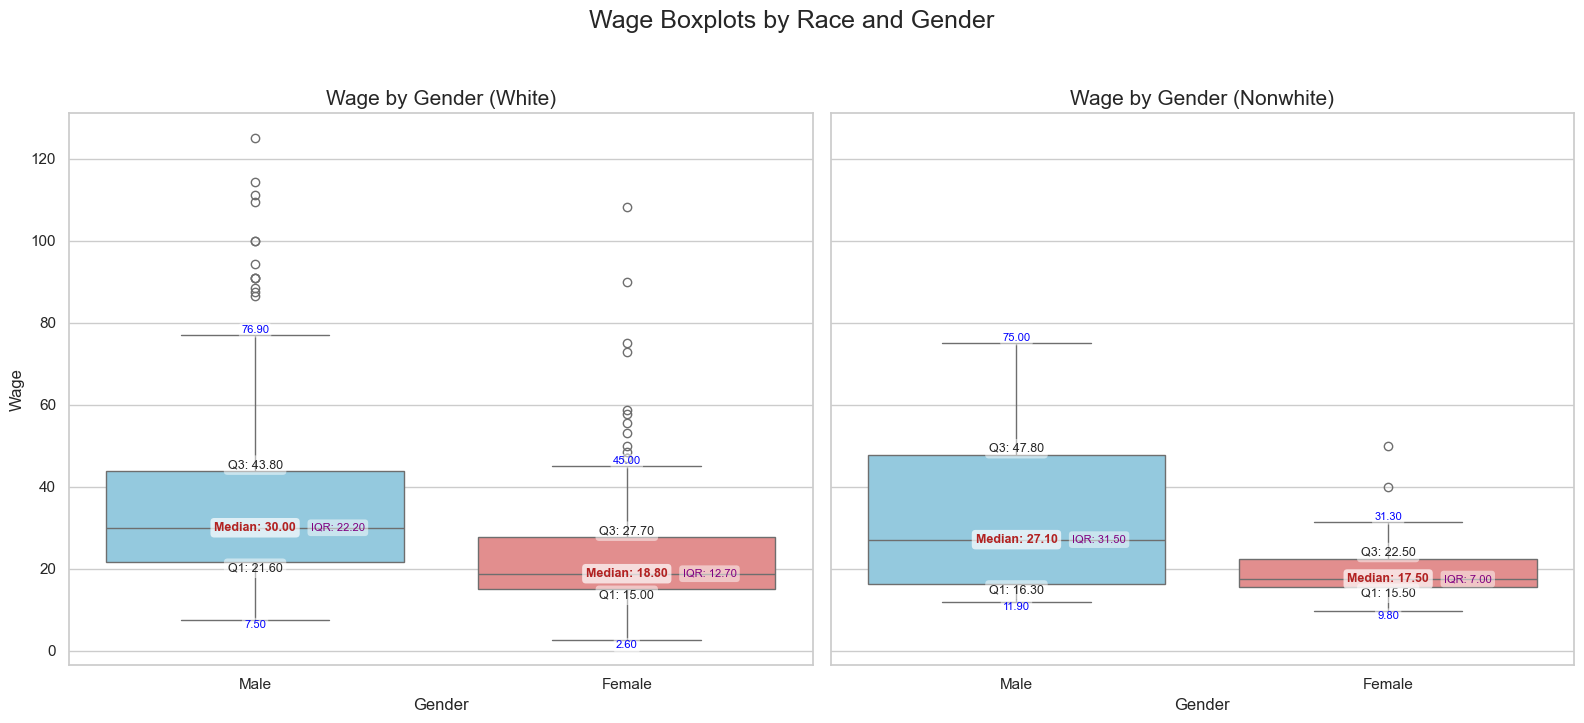

In [55]:
def annotate_boxplot_stats(ax, data_series, x_pos):
    """
    Annotates a boxplot on the given axes with Q1, Median, Q3, IQR, and whiskers.
    """
    if data_series.empty:
        return

    q1 = data_series.quantile(0.25)
    median = data_series.median()
    q3 = data_series.quantile(0.75)
    iqr = q3 - q1

    # Standard Tukey whiskers calculation
    # These are the values where the whiskers drawn by seaborn/matplotlib end
    lower_whisker_val = data_series[data_series >= (q1 - 1.5 * iqr)].min()
    upper_whisker_val = data_series[data_series <= (q3 + 1.5 * iqr)].max()

    # Common bounding box properties for annotations
    bbox_props_main = dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5, ec="none")
    bbox_props_median = dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, ec="none")
    bbox_props_whisker = dict(
        boxstyle="round,pad=0.2", fc="white", alpha=0.5, ec="none"
    )

    ax.text(
        x_pos,
        q1,
        f"Q1: {q1:.2f}",
        va="top",
        ha="center",
        fontsize=9,
        bbox=bbox_props_main,
    )
    ax.text(
        x_pos,
        median,
        f"Median: {median:.2f}",
        va="center",
        ha="center",
        color="firebrick",
        fontsize=9,
        fontweight="bold",
        bbox=bbox_props_median,
    )
    ax.text(
        x_pos,
        q3,
        f"Q3: {q3:.2f}",
        va="bottom",
        ha="center",
        fontsize=9,
        bbox=bbox_props_main,
    )
    ax.text(
        x_pos + 0.15,
        median,
        f"IQR: {iqr:.2f}",
        va="center",
        ha="left",
        color="purple",
        fontsize=8,
        bbox=bbox_props_main,
    )

    # Annotate whiskers only if they extend beyond the box and are valid numbers
    if pd.notna(lower_whisker_val) and lower_whisker_val < q1:
        ax.text(
            x_pos,
            lower_whisker_val,
            f"{lower_whisker_val:.2f}",
            va="top",
            ha="center",
            color="blue",
            fontsize=8,
            bbox=bbox_props_whisker,
        )

    if pd.notna(upper_whisker_val) and upper_whisker_val > q3:
        ax.text(
            x_pos,
            upper_whisker_val,
            f"{upper_whisker_val:.2f}",
            va="bottom",
            ha="center",
            color="blue",
            fontsize=8,
            bbox=bbox_props_whisker,
        )


# --- Main plotting code ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
group_labels = {0: "White", 1: "Nonwhite"}
gender_labels = {0: "Male", 1: "Female"}

for i, (nonwhite_val, group_df) in enumerate(df.groupby("nonwhite")):
    ax = axes[i]

    # Use a palette for distinct colors for male/female
    # legend=False as x-tick labels clarify the hue
    sns.boxplot(
        x="female",
        y="wage",
        data=group_df,
        ax=ax,
        hue="female",
        palette=["skyblue", "lightcoral"],
        legend=False,
    )

    ax.set_title(f"Wage by Gender ({group_labels[nonwhite_val]})", fontsize=15)
    ax.set_xlabel("Gender", fontsize=12)
    ax.set_ylabel(
        "Wage" if i == 0 else "", fontsize=12
    )  # Only show y-label on the first plot

    # Set custom x-tick labels
    tick_positions = sorted(group_df["female"].unique())
    tick_labels = [gender_labels[val] for val in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    # Annotate boxplot statistics for each gender group
    for j, female_val in enumerate(sorted(group_df["female"].unique())):
        subset_wages = group_df[group_df["female"] == female_val]["wage"]
        # 'j' corresponds to the x-position of the box (0 for Male, 1 for Female)
        annotate_boxplot_stats(ax, subset_wages, j)

plt.suptitle("Wage Boxplots by Race and Gender", fontsize=18, y=1.03)
plt.tight_layout()
plt.show()


Correlation Heatmap of Variables:


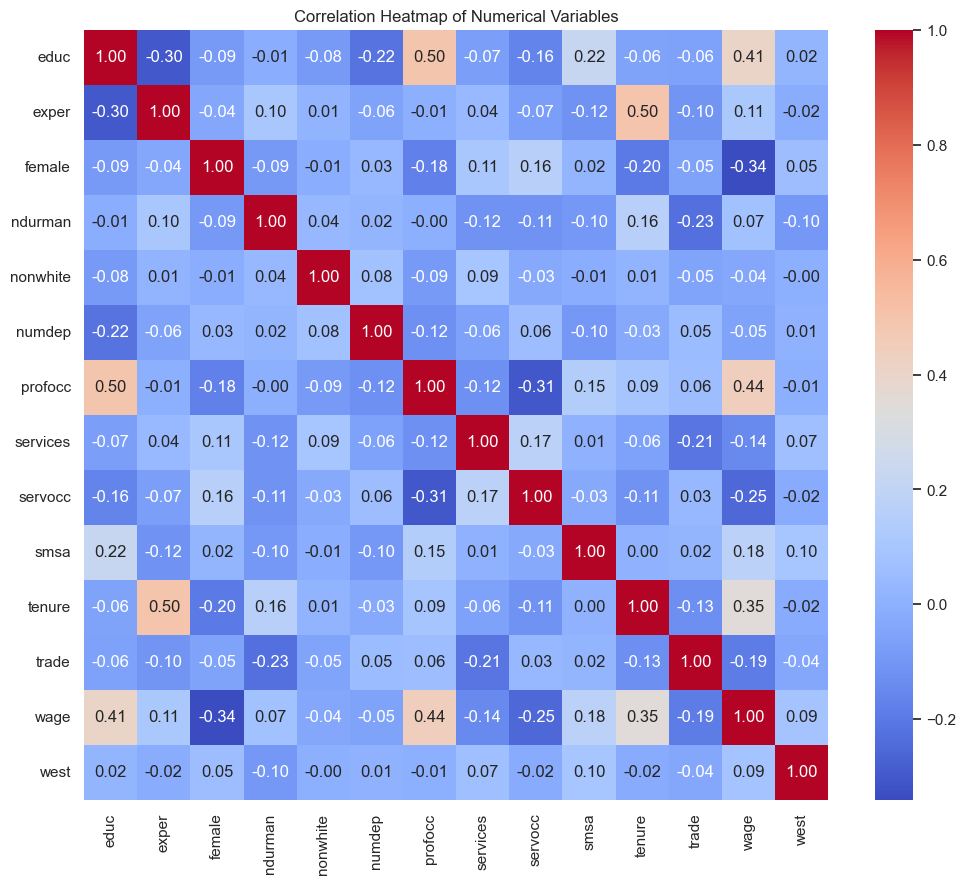

In [56]:
# Features correlation heatmap.

prediction_columns = ["wage_log", "wage_sqrt", "wage_inverse"]
columns_to_exclude_from_predictors = [] + prediction_columns
predictor_columns = df.columns.difference(columns_to_exclude_from_predictors)

print("\nCorrelation Heatmap of Variables:")
plt.figure(figsize=(12, 10))
sns.heatmap(df[predictor_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

#### Non-wage

##### Numeric

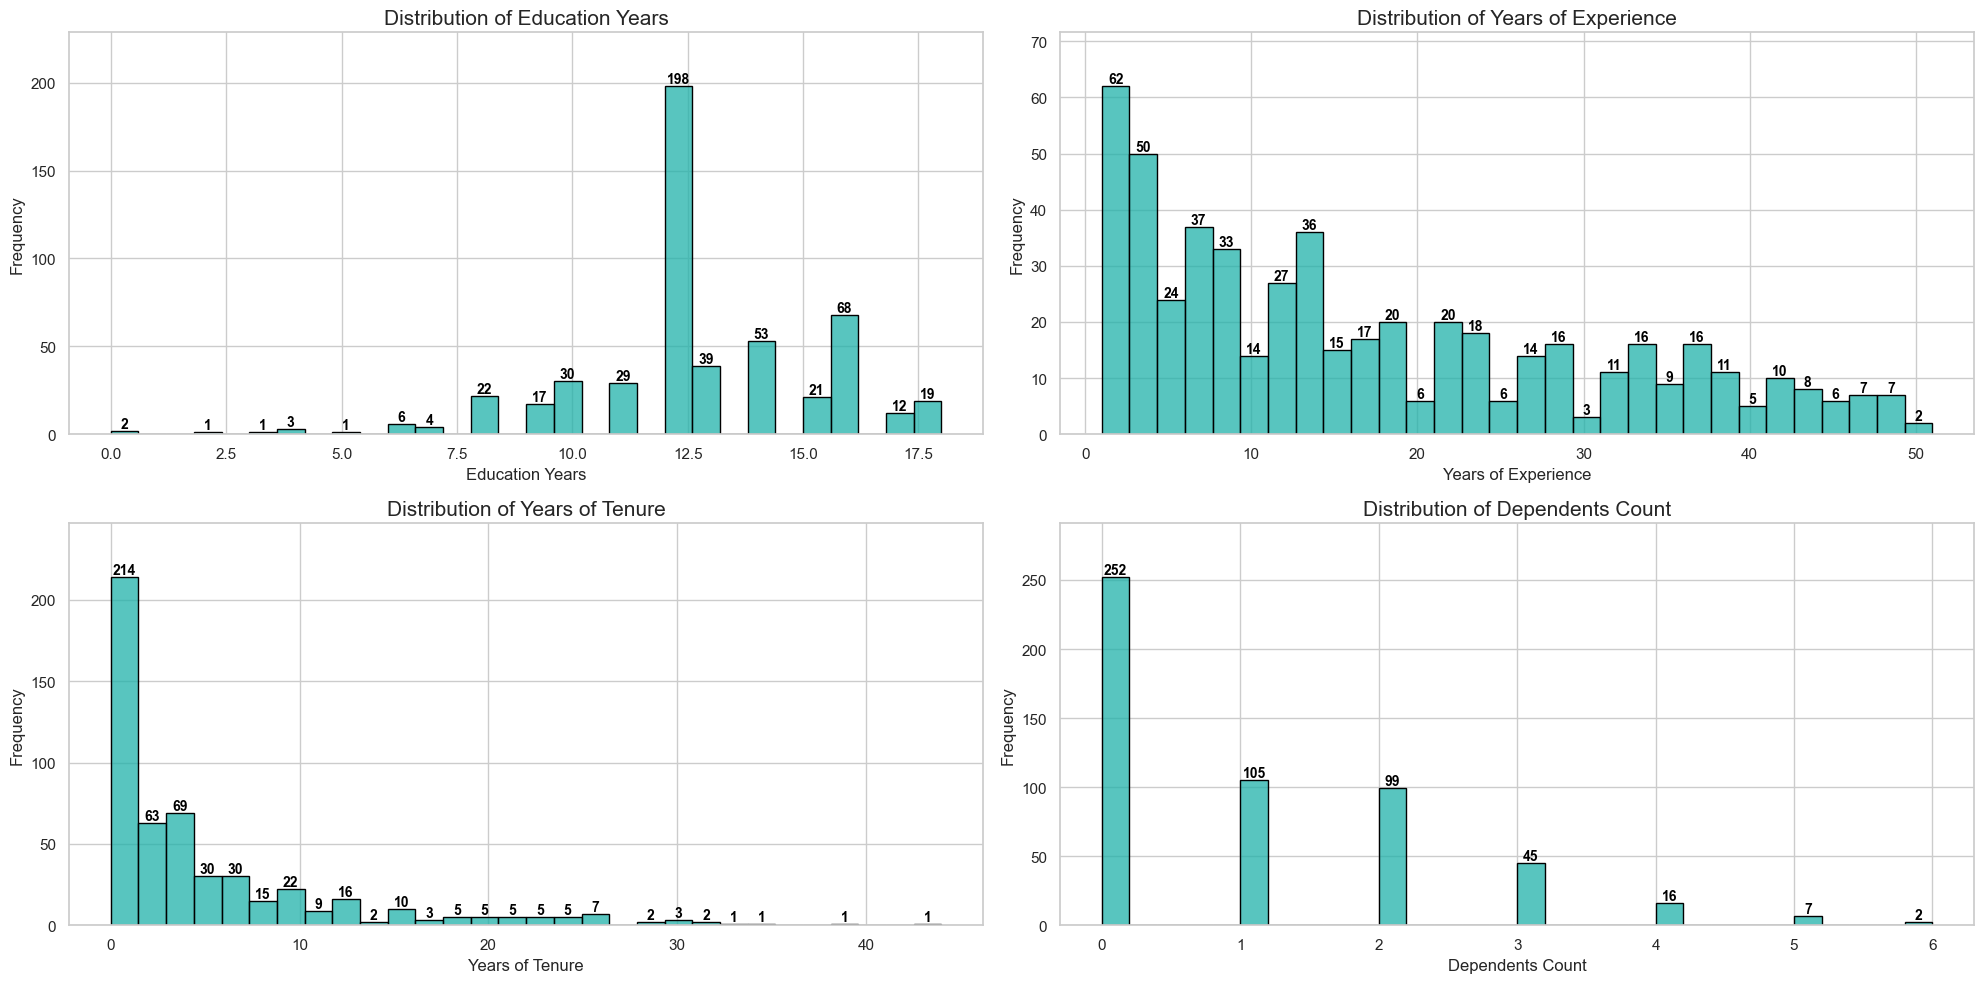

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

numeric_vars = [
    ("educ", "Education Years"),
    ("exper", "Years of Experience"),
    ("tenure", "Years of Tenure"),
    ("numdep", "Dependents Count"),
    # ("experience_per_education", "Years of Experience Per Year of Education"),
    # ("numdep_sq", "numdep_sq"),
]

bins_dict = {
    "educ": 30,
    "exper": 30,
    "tenure": 30,
    "numdep": 30,
    # "experience_per_education": 30,
    # "numdep_sq": 30,
}

for ax, (col, title) in zip(axes, numeric_vars):
    sns.histplot(
        data=df,
        x=col,
        bins=bins_dict[col],
        kde=False,
        color="lightseagreen",
        edgecolor="black",
        ax=ax,
    )
    # Add frequency labels
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(
                x,
                height,
                f"{int(height)}",
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="bold",
            )
    ax.set_title(f"Distribution of {title}", fontsize=15)
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)  # Add headroom for labels

plt.tight_layout()
plt.show()

##### Binary

The optimal dataset is balanced for every field value, ensuring all classes are as close to equally represented. In this dataset we see some columns are not balanced in terms of value frequency. For example:
- Non-white people represent 10.27% of entries (n=54).
- People living in the western region are 16.92% of entries (n=89).
- People working in the services industry are 10.08% of entries (n=53).
- People with a service occupation represent 14.07% of entries (n=74).

The column resulting for `OR`ing all imbalanced columns is much more balanced (n=215, ~40.8%).

#### Feature Engineering

In [58]:
# Define a small constant to sum in logged variables. Using 1 so that
# if the variable value is 0 then log(0 + 1) = 0, eliminating scenarios where
# the log results in negative numbers.
constant = 1

# Apply log transformation to 'exper', and 'tenure' using the new small constant
df["exper_log"] = np.log(df["exper"] + constant)
df["tenure_log"] = np.log(df["tenure"] + constant)

# Recreate squared terms for 'exper' and 'educ'
df["exper_sq"] = df["exper"] ** 2
df["educ_sq"] = df["educ"] ** 2

# Recreate interaction term between female and log of tenure
df["female_tenure_log"] = df["female"] * df["tenure_log"]

#### Regression

In [59]:
prediction_columns = [
    "female",
    "smsa",
    "west",
    "trade",
    "services",
    "profocc",
    "servocc",
    "exper_log",
    "tenure_log",
    "exper_sq",
    "educ_sq",
    "female_tenure_log",
]

X = df[prediction_columns]

# Add a column of ones for the intercept
X_plus_constant = sm.add_constant(X)
y = df.wage_log

model_sm = sm.OLS(y, X_plus_constant).fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:               wage_log   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     55.90
Date:                Sat, 31 May 2025   Prob (F-statistic):           4.10e-85
Time:                        18:51:04   Log-Likelihood:                -172.42
No. Observations:                 526   AIC:                             370.8
Df Residuals:                     513   BIC:                             426.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4165      0.08

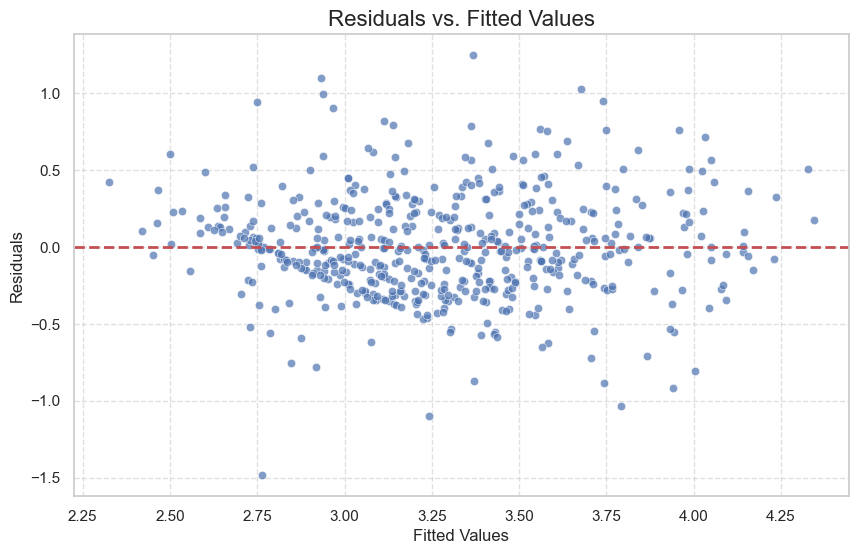

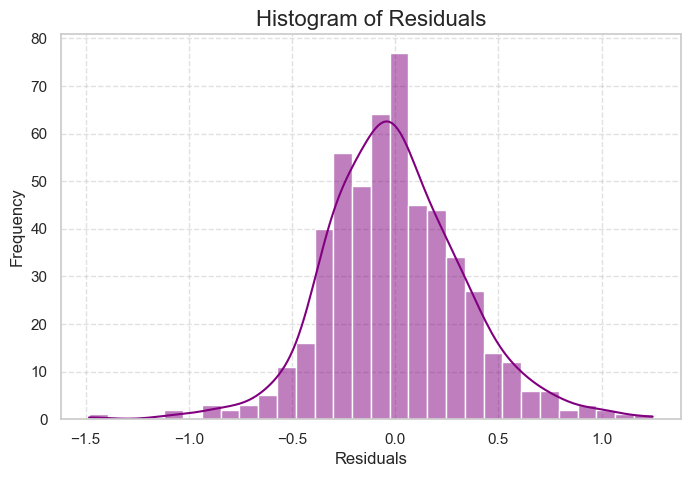

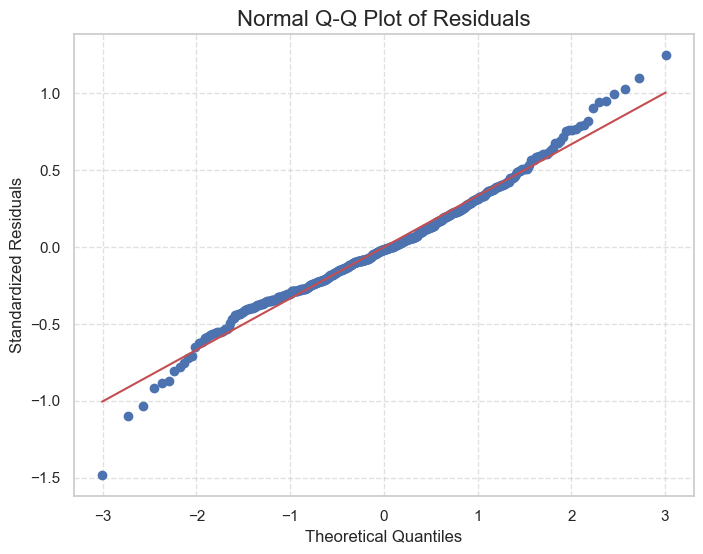

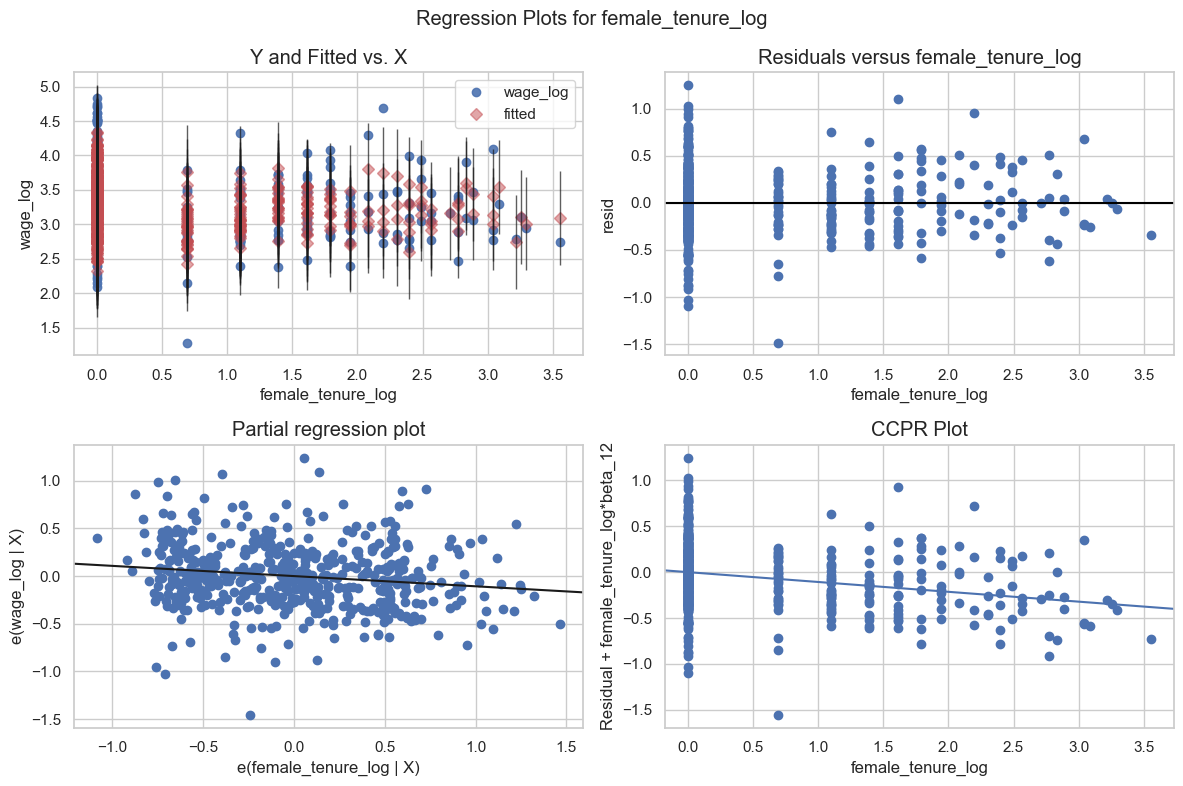

In [60]:
# Access Residuals and Fitted values
residuals = model_sm.resid
fitted_values = model_sm.fittedvalues

# Residual plots

# Plot 1: Residuals vs. Fitted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.7)
plt.axhline(y=0, color="r", linestyle="--", linewidth=2)  # Line at y=0 for reference
plt.title("Residuals vs. Fitted Values", fontsize=16)
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Interpretation of Residuals vs. Fitted Values plot:
# - A good plot shows a random scatter of points around the y=0 line, with no discernible pattern.
# - If you see a clear pattern (e.g., a curve, a fanning out/in shape), it suggests issues
#   like non-linearity, heteroscedasticity, or omitted variables.

# Plot 2: Histogram of Residuals (for normality check)
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color="purple", bins=30)
plt.title("Histogram of Residuals", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Interpretation of Histogram:
# - Ideally, the histogram should approximate a bell curve (normal distribution).
# - Significant skewness or multiple peaks might indicate problems.

# Plot 3: Normal Q-Q Plot of Residuals (for normality check)
# This is a more formal way to check for normality than a histogram.
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Residuals", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Standardized Residuals", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Interpretation of Q-Q Plot:
# - If the residuals are normally distributed, the points should fall approximately along the 45-degree line.
# - Deviations from the line, especially at the tails, indicate departures from normality.

# Statsmodels provides a convenient way to get common diagnostic plots:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(model_sm, "female_tenure_log", fig=fig)
plt.tight_layout()
plt.show()